In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-03 16:19:20.881460: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 16:19:20.903523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 16:19:21.232367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
prices_df = pd.read_csv('Data/Prices/MASHPEE.csv', header=0, parse_dates=[0], index_col=[0])
weather_df = pd.read_csv('Data/Weather/MASHPEE.csv', header=0, parse_dates=[0], index_col=[0])

In [4]:
# Get the range of dates in the DataFrame
date_range = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq='h')

# Reindex the DataFrame to include all dates in the range
prices_df = prices_df.reindex(date_range)

# Fill in missing values with the average of previous and next row
prices_df = prices_df.ffill().bfill().fillna(prices_df.mean())

In [5]:
date_range = pd.date_range(start=prices_df.index.min(), end=prices_df.index.max(), freq='h')

# Check if there are any missing dates in the DataFrame
missing_dates = date_range.difference(prices_df.index)

# Print the missing dates if there are any
if not missing_dates.empty:
    print("There are gaps in the data. The missing dates are:\n", missing_dates)
else:
    print("There are no gaps in the data.")

There are no gaps in the data.


In [6]:
weather_df.shape, prices_df.shape

((64076, 4), (64076, 1))

In [7]:
import holidays

df = pd.merge(prices_df, weather_df, left_index=True, right_index=True)
#df = prices_df

#df['Hour'] = df.index.hour
# df['Month'] = df.index.month
#df["Is_Weekend"] = df.index.day_name().isin(['Saturday', 'Sunday']).astype(int)

timestamp_s = df.index.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

us_holidays = holidays.US(years=range(2017, 2025))  # Adjust the year range as needed

# Create a function to check if a datetime is a holiday
def is_holiday(date):
    return 1 if date in us_holidays else 0

# Apply the function to create a new column
df['is_holiday'] = df.index.map(is_holiday)

df.head()

,energy,temperature_2m (°F),relative_humidity_2m (%),dew_point_2m (°F),cloud_cover (%),Day sin,Day cos,Year sin,Year cos,is_holiday
2017-01-01 00:00:00,34.86,23.7,47,6.2,0,2.504006e-13,1.000000,0.010364,0.999946,1
2017-01-01 01:00:00,33.72,24.9,46,6.9,0,2.588190e-01,0.965926,0.011081,0.999939,1
2017-01-01 02:00:00,32.40,26.8,48,9.9,0,5.000000e-01,0.866025,0.011798,0.999930,1
2017-01-01 03:00:00,25.88,28.5,51,12.6,0,7.071068e-01,0.707107,0.012515,0.999922,1
2017-01-01 04:00:00,29.65,29.4,51,13.6,0,8.660254e-01,0.500000,0.013231,0.999912,1


In [8]:
df.shape

(64076, 10)

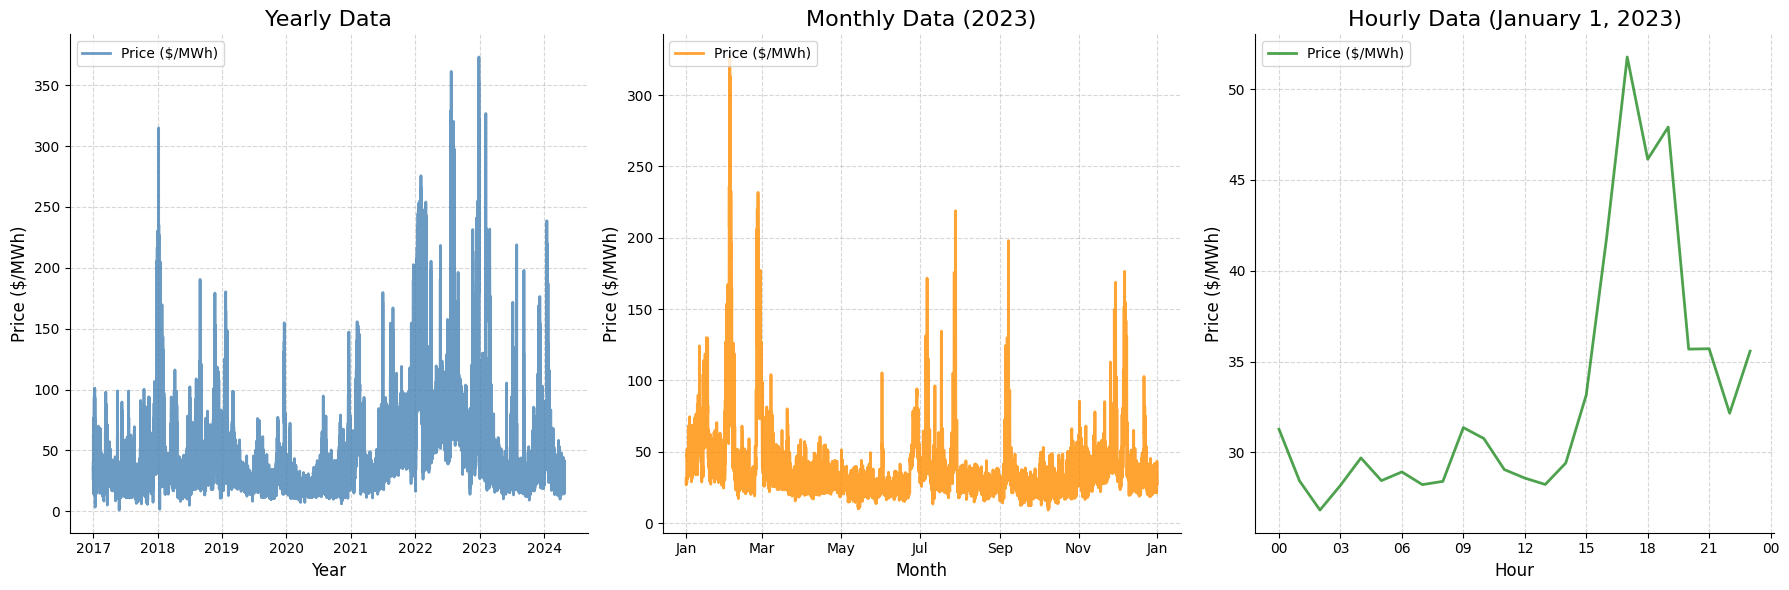

In [9]:
import matplotlib.dates as mdates

# Create a figure and axis for each plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Yearly Data
sns.lineplot(x=df.index, y='energy', data=df, ax=axs[0], color='steelblue', linewidth=2, alpha=0.8)
axs[0].set_title("Yearly Data", fontsize=16)
axs[0].set_xlabel("Year", fontsize=12)
axs[0].set_ylabel("Price ($/MWh)", fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Monthly Data (2023)
sns.lineplot(x=df[df.index.year == 2023].index, y='energy', data=df[df.index.year == 2023], ax=axs[1], color='darkorange', linewidth=2, alpha=0.8)
axs[1].set_title("Monthly Data (2023)", fontsize=16)
axs[1].set_xlabel("Month", fontsize=12)
axs[1].set_ylabel("Price ($/MWh)", fontsize=12)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axs[1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Hourly Data (January 1, 2023)
sns.lineplot(x=df[(df.index.year == 2023) & (df.index.month == 1) & (df.index.day == 1)].index, y='energy', data=df[(df.index.year == 2023) & (df.index.month == 1) & (df.index.day == 1)], ax=axs[2], color='forestgreen', linewidth=2, alpha=0.8)
axs[2].set_title("Hourly Data (January 1, 2023)", fontsize=16)
axs[2].set_xlabel("Hour", fontsize=12)
axs[2].set_ylabel("Price ($/MWh)", fontsize=12)
axs[2].xaxis.set_major_locator(mdates.HourLocator(interval=3))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%H"))
axs[2].grid(True, linestyle='--', alpha=0.5)

for ax in axs:
    ax.legend(['Price ($/MWh)'], loc='upper left')

# Remove borders from the plots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

fig.savefig('plot.png')

In [10]:
n_features = df.shape[1]
n_features

10

In [11]:
len(df)

64076

In [12]:
df_train = df[:60000]
df_test = df[60000:]

In [13]:
def get_window_data(arr, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(arr) - n_future + 1):
        X.append(arr[i - n_past:i])  # Selecting the past values
        y.append(arr[i:i + n_future, 0])  # Selecting the next 24 hours

    return np.array(X), np.array(y)

In [85]:
n_past = 24
n_future = 24

In [86]:
X_train, y_train = get_window_data(df_train.to_numpy(), n_past, n_future)
X_train.shape, y_train.shape

((59953, 24, 10), (59953, 24))

In [87]:
X_test, y_test = get_window_data(df_test.to_numpy(), n_past, n_future)
X_test.shape, y_test.shape

((4029, 24, 10), (4029, 24))

In [88]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [89]:
def plot_learning(history):
    tgts = ['loss']
    vtgts = ['val_loss']

    plt.figure(figsize=(10,3))
    for i, (tgt, val_tgt) in enumerate(zip(tgts, vtgts)):
      plt.subplot(1,2, i+1)
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      plt.ylabel('RMSE')
      plt.legend()
      plt.title(f"Training and validation {tgt}")

In [90]:
from tensorflow.keras.layers import Normalization

normalization = Normalization(axis=-1, name='normalization')
normalization.adapt(X_train)

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Flatten, Conv1D, MaxPooling1D

model = Sequential([
    InputLayer(shape=(n_past, n_features)),
    normalization,
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv1d_1'),
    MaxPooling1D(2, name='maxpool1d_1'),
    Flatten(name='flatten_1'),
    Dense(units=32, activation='relu', name='dense_1'),
    Dense(units=n_future, name='dense_out')
], name='cnn')

model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 24, 10)         │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 128)        │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,965 (210.80 KB)

 Trainable params: 53,944 (210.72 KB)

 Non-trainable params: 21 (88.00 B)

In [92]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(loss=root_mean_squared_error, optimizer='rmsprop')

In [93]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop_cb = EarlyStopping(patience=4)
best_model_cb = ModelCheckpoint('best_model_lstm.keras', save_best_only=True)

In [94]:
history = model.fit(X_train, y_train, epochs=100, 
                         validation_split=0.1, 
                         batch_size=168,
                         callbacks=[best_model_cb, early_stop_cb], shuffle=False)

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.5620 - val_loss: 15.2058
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 10.6789 - val_loss: 15.5420
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 10.0033 - val_loss: 15.0851
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 9.6586 - val_loss: 14.8242
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 9.4400 - val_loss: 14.7392
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 9.2840 - val_loss: 14.7457
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 9.1597 - val_loss: 14.7962
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 9.0597 - val_loss: 14.7700
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 8.9738 - val_loss: 14.6748
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 8.8957 - val_loss: 14.5160
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 8.8210 - val_loss: 14.3317
Epoch 1

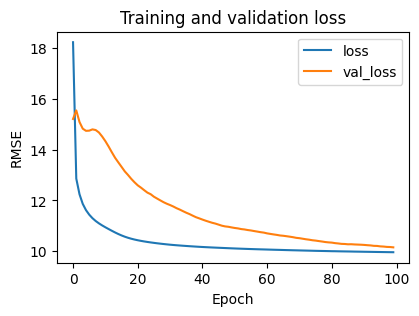

In [95]:
plot_learning(history)

In [102]:
from tensorflow.keras.models import load_model

y_pred = model.predict(X_test)
y_pred.shape

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


(4029, 24)

In [103]:
from sklearn.metrics import mean_absolute_percentage_error

mapes = []

for i in range(y_test.shape[0]):
    mapes.append(mean_absolute_percentage_error(y_test[i], y_pred[i]))

np.mean(mapes)

0.22882997049479042

In [98]:
y_test_reshaped = y_test.reshape(-1)
y_pred_reshaped = y_pred.reshape(-1)

In [99]:
df_results = pd.DataFrame({'Actual': y_test_reshaped, 'Prediction': y_pred_reshaped})

df_results['MAPE'] = (abs(df_results['Actual'] - df_results['Prediction']) / df_results['Actual']) * 100

In [100]:
df_results.head(24)

,Actual,Prediction,MAPE
0,29.25,21.979280,24.857161
1,23.03,23.380817,1.523306
2,21.72,23.319950,7.366253
3,21.41,21.127522,1.319376
4,20.56,21.400082,4.086000
5,26.19,26.266829,0.293351
6,34.78,32.848083,5.554677
7,34.99,37.221298,6.376960
8,31.79,36.610546,15.163719
9,34.39,31.948174,7.100397


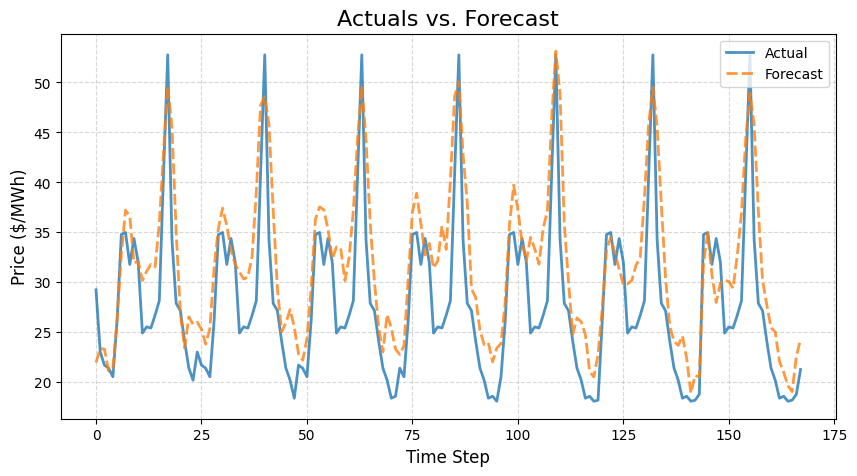

In [104]:
# Assuming y_test_reshaped and y_pred_reshaped are numpy arrays
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Actual': y_test_reshaped[:168], 'Forecast': y_pred_reshaped[:168]})

# Create a figure with subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Plot the data
sns.lineplot(data=df_plot, ax=axs, linewidth=2, alpha=0.8)
axs.set_title("Actuals vs. Forecast", fontsize=16)
axs.set_xlabel("Time Step", fontsize=12)
axs.set_ylabel("Price ($/MWh)", fontsize=12)
axs.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig('plot.png')

In [558]:
import pygad.kerasga

keras_ga = pygad.kerasga.KerasGA(model=lstm_model,
                                 num_solutions=10)

In [311]:
from tensorflow.keras.losses import MeanAbsoluteError

def fitness_func(ga_instance, solution, sol_idx):
    global X_train, y_train, keras_ga, lstm_model

    predictions = pygad.kerasga.predict(model=lstm_model,
                                        solution=solution,
                                        data=X_train)

    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    solution_fitness = 1.0/abs_error

    return solution_fitness

In [312]:
def on_generation(ga_instance):
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution()[1]}")

In [313]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = keras_ga.population_weights # Initial population of network weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=on_generation)

ga_instance.run()

/home/alic/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
You called `set_weights(weights)` on layer 'sequential_19' with a weight list of length 16, but the layer was expecting 22 weights.
Traceback (most recent call last):
  File "/home/alic/.local/lib/python3.10/site-packages/pygad/pygad.py", line 1708, in cal_pop_fitness
    fitness = self.fitness_func(self, sol, sol_idx)
  File "/tmp/ipykernel_263311/2580259693.py", line 6, in fitness_func
    predictions = pygad.kerasga.predict(model=lstm_model,
  File "/ho

ValueError: You called `set_weights(weights)` on layer 'sequential_19' with a weight list of length 16, but the layer was expecting 22 weights.

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
